## FUN5 data evaluation
I have measurement data for FUN5 device. 

1. with 16000 pi_gain for the CR drive we get Rabi period of 172 ns (fluxonium initialized in g) -> Rabi rate  =  1/172e-9 

    and with 16000 pi_gain for the CR drive we get Rabi period of 247 ns (fluxonium initialized in e) -> Rabi rate = 1/247e-9

    with the same gain whith best SD cancellation point we get Rabi period of ~580ns (fluxonium initialized in e)


2. Goal is to have the same 16000 gain i.e. -16.9 dbm power going into the fridge to the Fluxonium charge line and get a 50 ns CR gate with SD condition. So I will need to increase Jc, E_f to do so. 

### Recreate the measurment rabi rates

In [99]:
import scqubits as scq
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import scipy.optimize as opt
from qutip.qip.operations import cnot
import json
%matplotlib widget

# Load parameters from JSON
with open("cr_params.json", "r") as f:
    params = json.load(f)
FT_Device = params["FUN5_Left2"]
# FT_Device = params["FT_NICK"]
# FT_Device = params["UMA5"]

k = 120
trunc = 6

Fl1 = scq.Fluxonium(
    EJ=FT_Device['fluxonium']['EJ'],
    EC=FT_Device['fluxonium']['EC'],
    EL=FT_Device['fluxonium']['EL'],
    flux=0.5,
    cutoff=k,
    truncated_dim=trunc
)
Tr = scq.Transmon(
    EJ=FT_Device['transmon']['EJ'],
    EC=FT_Device['transmon']['EC'],
    ng=0,
    ncut=k,
    truncated_dim=trunc
)

J1T = FT_Device['Jc']

full_system = scq.HilbertSpace([Fl1, Tr])
full_system.add_interaction(
    g=J1T,
    op1=(Fl1.n_operator(), Fl1),
    op2=(Tr.n_operator(), Tr)
)
full_system.generate_bare_esys()
full_system.generate_lookup()

H_full = 2 * np.pi * full_system.hamiltonian()
evals, ekets = H_full.eigenstates()

n_Fl1_full = scq.identity_wrap(Fl1.n_operator(), Fl1, [Fl1, Tr])
n_Tr_full = scq.identity_wrap(Tr.n_operator(), Tr, [Fl1, Tr])
phi_Fl1_full = scq.identity_wrap(Fl1.phi_operator(), Fl1, [Fl1, Tr])


def get_dressed_epairs(evals, ekets):
    dressed_epairs = np.empty((5, 5), dtype=object)
    for i in range(4):
        for j in range(4):
            index = full_system.dressed_index((i, j))
            ztemp = qt.tensor(qt.basis(trunc, i), qt.basis(trunc, j)).overlap(ekets[index])
            np.angle(ztemp)
            dressed_epairs[i, j] = (evals[index], np.exp(-1j * np.angle(ztemp)) * ekets[index])
    return dressed_epairs

dressed_epairs = get_dressed_epairs(evals, ekets)


nF_10_11 =  (-0.02563215514407556+4.1294298305093917e-17j)
nF_00_01 =  (0.005093244655501203+1.6804991174731116e-16j)
nT =  (-1.1095490448974827+5.925142546269668e-17j)
eta =  0


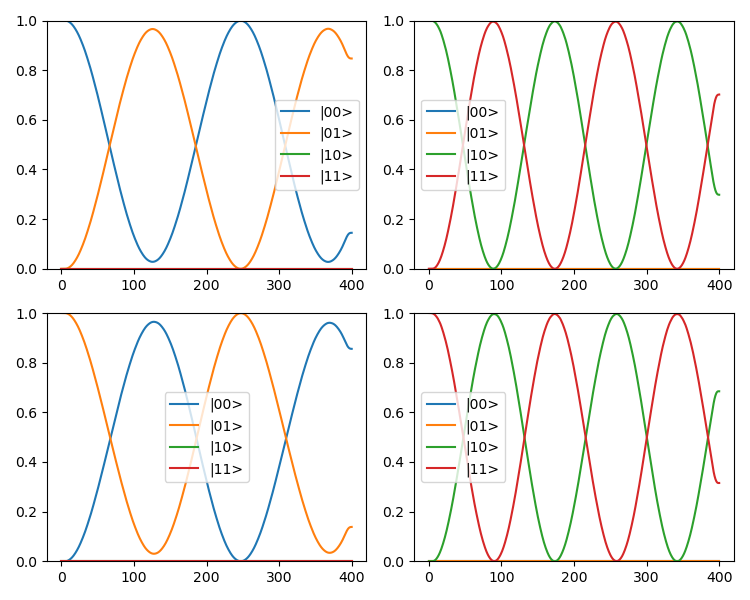

In [264]:
#trying to get the time evolution with different envelopes

def envelop_function(t, tg, t_r):
    if t < t_r:
        fnct = np.sin(np.pi * t / 2 / t_r) ** 2
    elif t < tg - t_r:
        fnct = 1.
    else:
        fnct = np.sin(np.pi * (tg - t) / 2 / t_r) ** 2
    return fnct


def time_dep(t, args):
    w_d = args['w_d']
    return 2 *3.14* np.cos(w_d*t) * envelop_function(t, args['t_g'], args['t_r'])


#FUN5
EFT  = .0115/ 93.92
EF   = .12/65
ET   = .163 / 93.92

# #UMA5
# EFT  = .00735/ 95
# EF   = .089/60
# ET   = .0418 / 95

nF_00_01   = (n_Fl1_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1]))
nF_10_11   = (n_Fl1_full.matrix_element(dressed_epairs[1, 0][1], dressed_epairs[1, 1][1]))
nT_00_01   = (n_Tr_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1]))

print('nF_10_11 = ', nF_10_11)
print('nF_00_01 = ', nF_00_01)
print('nT = ', nT)

t_r = 10
t_g = 400
t_list = np.linspace(0, t_g, 1000)
alpha =32.5
w_d = (dressed_epairs[1, 1][0] - dressed_epairs[1, 0][0])

args = {'t_g': t_g, 'w_d' : w_d, 't_r': t_r}

def eta(EF, EFT, ET, nF, nT):
    """
       Compute eta from the drive cancellation equation:
       eta = - ( EF*nF + EFT*nT ) / ( ET*nT )
    """
    numerator = EF * nF + EFT * nT
    denominator = ET * nT
    return - numerator / denominator

eta = 0#np.real(eta(EF, EFT, ET, nF, nT)) # means no selective darkening
print('eta = ', eta)

H_tot = [H_full, [alpha * (EF * n_Fl1_full + EFT * n_Tr_full + eta * ET * n_Tr_full), time_dep]]


def prob_lists(psi):
    p_lists = [[] for _ in range(4)]
    for ndx in range(len(psi)):
        psi_t = psi[ndx]
        for i in range(4):
            idx1 = i // 2
            idx2 = i % 2
            p_lists[i].append(np.abs(psi_t.overlap(dressed_epairs[idx1, idx2][1]))**2)
    return p_lists

def temp_opt_freq_gen(H_tot, args):
    fig, axs = plt.subplots(2, 2, figsize=(7.5, 6))  # Create 2x2 subplots
    axs = axs.flatten()  # Flatten the 2D array for easier iteration

    initial_states = [
        dressed_epairs[0, 0][1],
        dressed_epairs[1, 0][1],
        dressed_epairs[0, 1][1],
        dressed_epairs[1, 1][1],
    ]

    for i, initial_state in enumerate(initial_states):
        p_lists = prob_lists(qt.sesolve(H_tot, initial_state, t_list, args=args).states)

        # Plot only curves with values above 1e-3
        for j, p_list in enumerate(p_lists):
            if any(p > 0 for p in p_list):
                label = "|" + str(j // 2) + str(j % 2) + ">"
                # axs[i].semilogy(t_list, p_list, label=label)
                axs[i].plot(t_list, p_list, label=label)

        axs[i].set_ylim(0, 1)
        axs[i].legend()
        axs[i].set_facecolor('white')

    plt.tight_layout()
    plt.show()

temp_opt_freq_gen(H_tot, args)

In [242]:
print(r'|⟨00̃| ε_F n_{Fl1} + (ε_{FT} + η ε_T) n_{Tr} |01̃⟩|', ' = ', np.abs(alpha*(EF * nF_00_01 + (EFT + eta * ET) * nT)))
print(r'|⟨10̃| ε_F n_{Fl1} + (ε_{FT} + η ε_T) n_{Tr} |11̃⟩|', ' = ', np.abs(alpha*(EF * nF_10_11 + (EFT + eta * ET) * nT)))

|⟨00̃| ε_F n_{Fl1} + (ε_{FT} + η ε_T) n_{Tr} |01̃⟩|  =  0.004109800928958196
|⟨10̃| ε_F n_{Fl1} + (ε_{FT} + η ε_T) n_{Tr} |11̃⟩|  =  0.005953324916932801


Here we see, at \alpha  = 32.5 we get similar rabi rates but in measurement I guess we have g and e state initializtion wrong. anyways, this alpha in my simulation is equaivalent to 16.9 dbm(16000 pi gain) on the current setup. 

Next, I will try SD condition with this fixed drive power

In [265]:
args = {'t_g': t_g, 'w_d' : w_d, 't_r': t_r}
t_r = 10
t_g = 400
t_list = np.linspace(0, t_g, 1000)
alpha =32.5

def eta(EF, EFT, ET, nF, nT):
    """
       Compute eta from the drive cancellation equation:
       eta = - ( EF*nF + EFT*nT ) / ( ET*nT )
    """
    numerator = EF * nF + EFT * nT
    denominator = ET * nT
    return - numerator / denominator
eta = np.real(eta(EF, EFT, ET, nF_00_01, nT_00_01)) # means no selective darkening
print('eta = ', eta)

def time_dep(t, args):
    w_d = args['w_d']
    return 2 *3.14* np.cos(w_d*t) * envelop_function(t, args['t_g'], args['t_r'])


eta =  -0.0656691508501839


In [98]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
# --- sweep around your chosen center (opteta_p must be defined)
eta_values = np.linspace(eta - .05, eta + .1, 15001)

# --- dressed computational kets
e1 = dressed_epairs[0, 0][1]  # |~00>
e2 = dressed_epairs[0, 1][1]  # |~01>
e3 = dressed_epairs[1, 0][1]  # |~10>
e4 = dressed_epairs[1, 1][1]  # |~11>

# --- precompute the eta-independent part of the operator:
#     O(eta) = EF * n_Fl1_full + (EFT + ET*eta) * n_Tr_full
#            = (EF * n_Fl1_full + EFT * n_Tr_full) + (ET * eta) * n_Tr_full
O_base = EF * n_Fl1_full + EFT * n_Tr_full
O_tr   = ET * n_Tr_full  # this multiplies eta_p each step

# --- compute matrix elements for each eta_p
matrix_elements_00_01 = [
    (O_base + eta_p * O_tr).matrix_element(e1, e2) for eta_p in eta_values
]
matrix_elements_10_11 = [
    (O_base + eta_p * O_tr).matrix_element(e3, e4) for eta_p in eta_values
]

# --- magnitudes (you can also keep phases if you want)
magnitudes_00_01 = np.abs(matrix_elements_00_01)
magnitudes_10_11 = np.abs(matrix_elements_10_11)

# --- plotting
plt.figure(figsize=(9, 4.5))
plt.semilogy(
    eta_values, magnitudes_00_01,
    label=(r'$|\langle \tilde{00} |\, \mathcal{E}_F n_{\mathrm{Fl1}}'
           r'+(\mathcal{E}_{FT}+\eta\,\mathcal{E}_T)\,n_{\mathrm{Tr}} \,| \tilde{01}\rangle|$')
)
plt.semilogy(
    eta_values, magnitudes_10_11,
    label=(r'$|\langle \tilde{10} |\, \mathcal{E}_F n_{\mathrm{Fl1}}'
           r'+(\mathcal{E}_{FT}+\eta\,\mathcal{E}_T)\,n_{\mathrm{Tr}} \,| \tilde{11}\rangle|$')
)

plt.axvline(eta, color='gray', linestyle='--', label=r'$\eta_{\mathrm{opt}}$')
plt.xlabel(r'$\eta$')
plt.ylabel('Matrix element magnitude')
plt.title('Drive matrix elements vs $\eta$')
plt.legend()
plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.show()


TypeError: unsupported operand type(s) for -: 'function' and 'float'

eta =  -0.27892827863828284


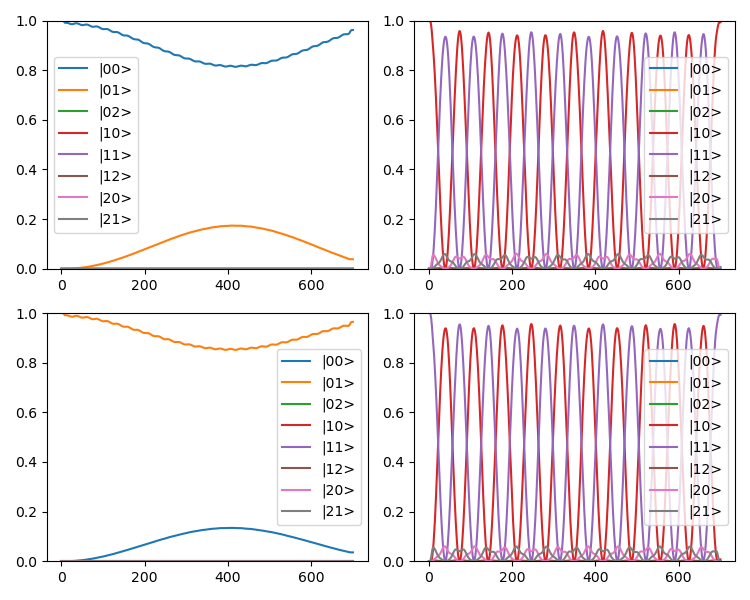

|⟨00̃| ε_F n_{Fl1} + (ε_{FT} + η * ε_T) n_{Tr} |01̃⟩|  =  6.5233359105695315e-16
|⟨10̃| ε_F n_{Fl1} + (ε_{FT} + η * ε_T) n_{Tr} |11̃⟩|  =  0.015468469471293406


In [19]:

args = {'t_g': t_g, 'w_d' : w_d, 't_r': t_r}
t_r = 10
t_g = 700
t_list = np.linspace(0, t_g, 500)
alpha =32.5*2

def time_dep(t, args):
    w_d = args['w_d']
    return 2 *3.14* np.cos(w_d*t) * envelop_function(t, args['t_g'], args['t_r'])


def eta(EF, EFT, ET, nF, nT):
    """
       Compute eta from the drive cancellation equation:
       eta = - ( EF*nF + EFT*nT ) / ( ET*nT )
    """
    numerator = EF * nF + EFT * nT
    denominator = ET * nT
    return - numerator / denominator

eta = np.real(eta(EF, EFT, ET, nF_00_01, nT)) # means no selective darkening
print('eta = ', eta)
w_d = (dressed_epairs[1, 1][0] - dressed_epairs[1, 0][0])
args = {'t_g': t_g, 'w_d' : w_d, 't_r': t_r}


H_tot = [H_full, [alpha * (EF * n_Fl1_full + EFT * n_Tr_full + eta * ET * n_Tr_full), time_dep]]


# def prob_lists(psi):
#     p_lists = [[] for _ in range(4)]
#     for ndx in range(len(psi)):
#         psi_t = psi[ndx]
#         for i in range(4):
#             idx1 = i // 2
#             idx2 = i % 2
#             p_lists[i].append(np.abs(psi_t.overlap(dressed_epairs[idx1, idx2][1]))**2)
#     return p_lists

def prob_lists(psi):
    p_lists = [[] for _ in range(9)]
    for ndx in range(len(psi)):
        psi_t = psi[ndx]
        for i in range(8):
            idx1 = i // 3
            idx2 = i % 3
            p_lists[i].append(np.abs(psi_t.overlap(dressed_epairs[idx1, idx2][1]))**2)
    return p_lists


def temp_opt_freq_gen(H_tot, args):
    fig, axs = plt.subplots(2, 2, figsize=(7.5, 6))  # Create 2x2 subplots
    axs = axs.flatten()  # Flatten the 2D array for easier iteration

    initial_states = [
        dressed_epairs[0, 0][1],
        dressed_epairs[1, 0][1],
        dressed_epairs[0, 1][1],
        dressed_epairs[1, 1][1],
    ]

    for i, initial_state in enumerate(initial_states):
        p_lists = prob_lists(qt.sesolve(H_tot, initial_state, t_list, args=args).states)

        # Plot only curves with values above 1e-3
        for j, p_list in enumerate(p_lists):
            if any(p > 0 for p in p_list):
                # label = "|" + str(j // 2) + str(j % 2) + ">"
                label = "|" + str(j // 3) + str(j % 3) + ">"
                # axs[i].semilogy(t_list, p_list, label=label)
                axs[i].plot(t_list, p_list, label=label)

        axs[i].set_ylim(0, 1)
        axs[i].legend()
        axs[i].set_facecolor('white')

    plt.tight_layout()
    plt.show()

temp_opt_freq_gen(H_tot, args)

print(r'|⟨00̃| ε_F n_{Fl1} + (ε_{FT} + η * ε_T) n_{Tr} |01̃⟩|', ' = ', np.abs(alpha*(EF * nF_00_01 + (EFT + eta * ET) * nT_00_01)))
print(r'|⟨10̃| ε_F n_{Fl1} + (ε_{FT} + η * ε_T) n_{Tr} |11̃⟩|', ' = ', np.abs(alpha*(EF * nF_10_11 + (EFT + eta * ET) * nT_00_01)))

The above eta value (SD eta properly recreates the measured data. that means our SD condition is not very good. 

It is possible we are cancelling the 10-11 transtion. lets check what that would look like

eta =  -0.09515723418973633


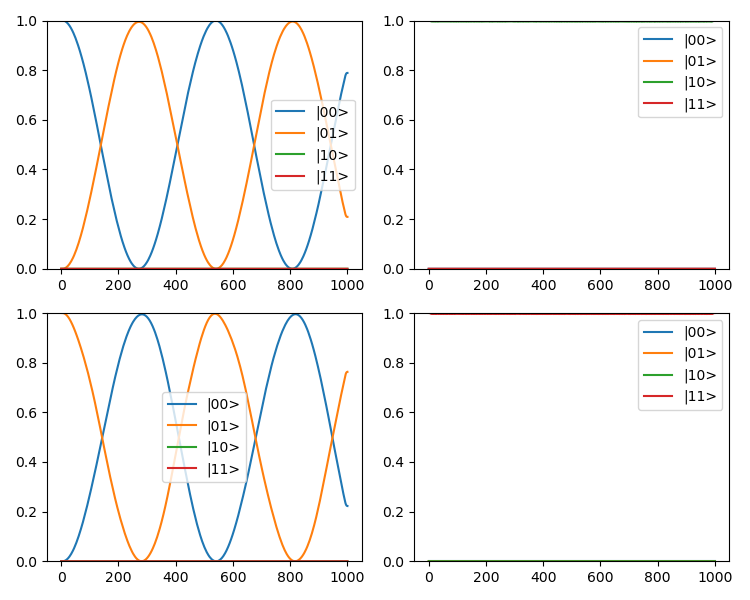

In [52]:
nF_00_01   = (n_Fl1_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1]))
nF_10_11   = (n_Fl1_full.matrix_element(dressed_epairs[1, 0][1], dressed_epairs[1, 1][1]))
nT_00_01   = (n_Tr_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1]))
nT_10_11   = (n_Tr_full.matrix_element(dressed_epairs[1, 0][1], dressed_epairs[1, 1][1]))

w_d = (dressed_epairs[0, 0][0] - dressed_epairs[0, 1][0])

def eta(EF, EFT, ET, nF, nT):
    """
       Compute eta from the drive cancellation equation:
       eta = - ( EF*nF + EFT*nT ) / ( ET*nT )
    """
    numerator = EF * nF + EFT * nT
    denominator = ET * nT
    return - numerator / denominator

eta = np.real(eta(EF, EFT, ET, nF_10_11, nT_10_11)) # means no selective darkening
print('eta = ', eta)

args = {'t_g': t_g, 'w_d' : w_d, 't_r': t_r}
eta = eta
H_tot = [H_full, [alpha * (EF * n_Fl1_full + EFT * n_Tr_full + eta * ET * n_Tr_full), time_dep]]


def prob_lists(psi):
    p_lists = [[] for _ in range(4)]
    for ndx in range(len(psi)):
        psi_t = psi[ndx]
        for i in range(4):
            idx1 = i // 2
            idx2 = i % 2
            p_lists[i].append(np.abs(psi_t.overlap(dressed_epairs[idx1, idx2][1]))**2)
    return p_lists

def temp_opt_freq_gen(H_tot, args):
    fig, axs = plt.subplots(2, 2, figsize=(7.5, 6))  # Create 2x2 subplots
    axs = axs.flatten()  # Flatten the 2D array for easier iteration

    initial_states = [
        dressed_epairs[0, 0][1],
        dressed_epairs[1, 0][1],
        dressed_epairs[0, 1][1],
        dressed_epairs[1, 1][1],
    ]

    for i, initial_state in enumerate(initial_states):
        p_lists = prob_lists(qt.sesolve(H_tot, initial_state, t_list, args=args).states)

        # Plot only curves with values above 1e-3
        for j, p_list in enumerate(p_lists):
            if any(p > 0 for p in p_list):
                label = "|" + str(j // 2) + str(j % 2) + ">"
                # axs[i].semilogy(t_list, p_list, label=label)
                axs[i].plot(t_list, p_list, label=label)

        axs[i].set_ylim(0, 1)
        axs[i].legend()
        axs[i].set_facecolor('white')

    plt.tight_layout()
    plt.show()

temp_opt_freq_gen(H_tot, args)

Well, seems at the two different SD condition both gives the same CR rate at the best SD position. Now the question is can we do finer sweep to get this rate? Also, since I am considering simulated data to get the crosstalk and not measurement data, may be this is the best CR SD position we can get. That is a possibility. Will check this later after FUN14 submission maybe


### check what is the coherent fidelity in this condition? 

In [7]:
U_ideal = 0 # Identity operator in the computational subspace
U_ideal += dressed_epairs[0, 0][1] * dressed_epairs[0, 0][1].dag()
U_ideal += dressed_epairs[0, 1][1] * dressed_epairs[0, 1][1].dag()
U_ideal += dressed_epairs[1, 1][1] * dressed_epairs[1, 0][1].dag()
U_ideal += dressed_epairs[1, 0][1] * dressed_epairs[1, 1][1].dag()

def U_full2comp(U_f):
    U4x4 = 1j*np.zeros([4,4])
    for dx in range(2):
        for jx in range(2):
            for kx in range(2):
                for lx in range(2):
                    U4x4[2*dx+jx,2*kx+lx] = U_f.matrix_element(dressed_epairs[dx,jx][1],dressed_epairs[kx,lx][1])
    return qt.Qobj(U4x4)

idcomp = qt.Qobj(cnot().full())

def envelop_function(t, tg, t_r):
    if t < t_r:
        fnct = np.sin(np.pi * t / 2 / t_r) ** 2
    elif t < tg - t_r:
        fnct = 1.
    else:
        fnct = np.sin(np.pi * (tg - t) / 2 / t_r) ** 2
    return fnct

def time_dep(t, args):
    w_d = args['w_d']
    return 2 * np.cos(w_d*t) * envelop_function(t,args['t_g'], args['t_r'])

# needed functions
def evolution_psi_microwave(H_tot, psi0, t_points, args):
    result = qt.sesolve(H_tot, psi0, t_points, args=args, options=qt.Options(nsteps=25000))
    return result.states

def evolution_subspace(H_tot, args, subspace_states, t_points):
    psi_t = []
    for ind, psi_0 in enumerate(subspace_states):
        temp = evolution_psi_microwave(H_tot, psi_0, t_points=t_points, args=args)
        psi_t.append(temp)

    U_t = np.empty_like(t_points, dtype=object)
    ind_t = len(t_points) - 1
    U = 0
    for ind, psi_0 in enumerate(subspace_states):
        U += psi_t[ind][ind_t] * psi_0.dag()
    U_t[ind_t] = U
    return U_t

def gate(H_tot, args):
    comp_space = [dressed_epairs[0, 0][1], dressed_epairs[0, 1][1], dressed_epairs[1, 0][1], dressed_epairs[1, 1][1]]
    U_t = evolution_subspace(H_tot, args, comp_space, t_list)
    U_act = U_t[-1]
    return U_act

def abs_fidelity_CX1(params, t_g, t_r):
    alpha, eta, detuning = params
    w_d = (dressed_epairs[1, 1][0] - dressed_epairs[1, 0][0])*detuning
    H_tot = [H_full, [alpha * (n_Fl1_full + eta * n_Tr_full), time_dep]]
    
    args = {'t_g': t_g, 'w_d' : w_d, 't_r': t_r}
    
    U_act = qt.Qobj(np.abs(U_full2comp(gate(H_tot, args)).full()))

    op1 = U_act.dag() * U_act
    op2 = idcomp.dag() * U_act
    fidelity = (op1.tr() + (abs(op2.tr()))**2) / 20.0
    return -fidelity

def abs_fidelity_CX1_with_crosstalk(params, t_g, t_r, EF, EFT, ET): 
    
    alpha, eta_p, detuning = params
    w_d = (dressed_epairs[1, 1][0] - dressed_epairs[1, 0][0])*detuning
    H_tot = [H_full, [alpha * (EF * n_Fl1_full +(EFT + ET * eta_p) * n_Tr_full), time_dep]]
    args = {'t_g': t_g, 'w_d' : w_d, 't_r': t_r}
    U_act = qt.Qobj(np.abs(U_full2comp(gate(H_tot, args)).full()))
    op1 = U_act.dag() * U_act
    op2 = idcomp.dag() * U_act
    fidelity = (op1.tr() + (abs(op2.tr()))**2) / 20.0
    return -fidelity

def eta(EF, EFT, ET, nF, nT):
    """
       Compute eta from the drive cancellation equation:
       eta = - ( EF*nF + EFT*nT ) / ( ET*nT )
    """
    numerator = EF * nF + EFT * nT
    denominator = ET * nT
    return - numerator / denominator



Well this is how it is now. we will not get better results. how about also tune the detuning? 

In [277]:
nF   = (n_Fl1_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1]))
nT   = (n_Tr_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1]))
EFT  = .011/95.5
EF   = .12/65
ET   = .163 / 95.5

eta_p = eta(EF, EFT, ET, nF, nT)
alpha = 30*5
detuning = 0.9999
t_g = 240
t_r = 10
t_list = np.linspace(0, t_g, 1000)

initial_guess = [alpha, eta_p, detuning]


result = opt.minimize(abs_fidelity_CX1_with_crosstalk, initial_guess, args=(t_g, t_r, EF, EFT, ET), method='Nelder-Mead', options={'fatol': 0.00001, 'xatol': 0.00001})
optalpha, opteta_p, optdetuning = result.x

w_d = (dressed_epairs[1, 1][0] - dressed_epairs[1, 0][0])*optdetuning
H_tot = [H_full, [optalpha * (EF * n_Fl1_full + (EFT + ET * opteta_p) * n_Tr_full), time_dep]]

args = {'t_g': t_g, 'w_d' : w_d, 't_r': t_r}

U_act = np.abs(U_full2comp(gate(H_tot, args)).full())

max_fidelity = -result.fun

a = 1 - U_act[0,0]
b = 1 - U_act[1,1]
c = 1 - U_act[2,3]
d = 1 - U_act[3,2]

dark = 2*(a + b)/5
flip = 2*(c + d)/5

bright = 2/5 * abs(U_act[0,1])

leak = abs(1 - np.trace(np.transpose(U_act)@U_act)/4)


print(f"dark = {dark:.3e}, flip = {flip:.3e}, leak = {leak:.3e}, max_fidelity = {max_fidelity:.6f}")

opt_names = ("optalpha", "opteta_p", "optdetuning")
opt_vals = result.x
print("Optimized parameters:")
for name, val in zip(opt_names, opt_vals):
    print(f"  {name:>12s} = {val:.6g}")

print(f"Optimizer success: {result.success}, nit: {getattr(result, 'nit', 'N/A')}, message: {result.message}")


dark = 7.635e-04, flip = 5.161e-04, leak = 9.557e-04, max_fidelity = 0.998530
Optimized parameters:
      optalpha = 119.486+0j
      opteta_p = -0.0618594+1.62356e-16j
   optdetuning = 1+0j
Optimizer success: True, nit: 95, message: Optimization terminated successfully.


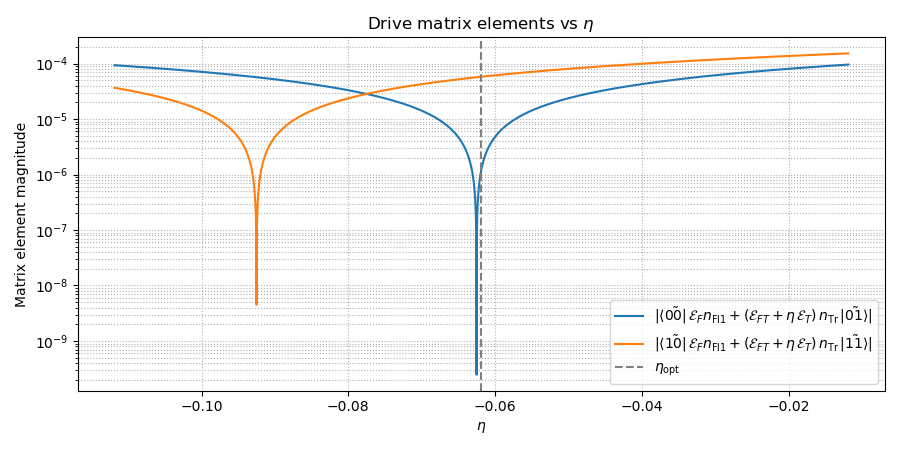

In [278]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
# --- sweep around your chosen center (opteta_p must be defined)
eta_values = np.linspace(opteta_p - .05, opteta_p + .05, 15001)

# --- dressed computational kets
e1 = dressed_epairs[0, 0][1]  # |~00>
e2 = dressed_epairs[0, 1][1]  # |~01>
e3 = dressed_epairs[1, 0][1]  # |~10>
e4 = dressed_epairs[1, 1][1]  # |~11>

# --- precompute the eta-independent part of the operator:
#     O(eta) = EF * n_Fl1_full + (EFT + ET*eta) * n_Tr_full
#            = (EF * n_Fl1_full + EFT * n_Tr_full) + (ET * eta) * n_Tr_full
O_base = EF * n_Fl1_full + EFT * n_Tr_full
O_tr   = ET * n_Tr_full  # this multiplies eta_p each step

# --- compute matrix elements for each eta_p
matrix_elements_00_01 = [
    (O_base + eta_p * O_tr).matrix_element(e1, e2) for eta_p in eta_values
]
matrix_elements_10_11 = [
    (O_base + eta_p * O_tr).matrix_element(e3, e4) for eta_p in eta_values
]

# --- magnitudes (you can also keep phases if you want)
magnitudes_00_01 = np.abs(matrix_elements_00_01)
magnitudes_10_11 = np.abs(matrix_elements_10_11)

# --- plotting
plt.figure(figsize=(9, 4.5))
plt.semilogy(
    eta_values, magnitudes_00_01,
    label=(r'$|\langle \tilde{00} |\, \mathcal{E}_F n_{\mathrm{Fl1}}'
           r'+(\mathcal{E}_{FT}+\eta\,\mathcal{E}_T)\,n_{\mathrm{Tr}} \,| \tilde{01}\rangle|$')
)
plt.semilogy(
    eta_values, magnitudes_10_11,
    label=(r'$|\langle \tilde{10} |\, \mathcal{E}_F n_{\mathrm{Fl1}}'
           r'+(\mathcal{E}_{FT}+\eta\,\mathcal{E}_T)\,n_{\mathrm{Tr}} \,| \tilde{11}\rangle|$')
)

plt.axvline(opteta_p, color='gray', linestyle='--', label=r'$\eta_{\mathrm{opt}}$')
plt.xlabel(r'$\eta$')
plt.ylabel('Matrix element magnitude')
plt.title('Drive matrix elements vs $\eta$')
plt.legend()
plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.show()


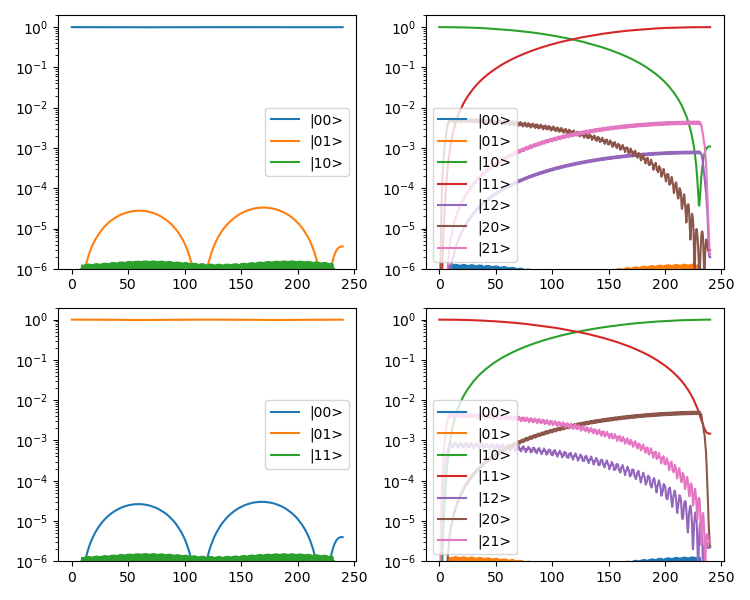

In [279]:

check = False
if check:
    alpha = 7000
    detuning = 0.9999
    t_g = 200
    t_r = 20
    t_list = np.linspace(0, t_g, 1000)
    w_d = (dressed_epairs[1, 1][0] - dressed_epairs[1, 0][0])*detuning
    H_tot = [H_full, [alpha * (EF * n_Fl1_full + (EFT + ET * eta_val) * n_Tr_full), time_dep]]
else:
    H_tot = [H_full, [optalpha * (EF * n_Fl1_full + (EFT + ET * opteta_p) * n_Tr_full), time_dep]]


def prob_lists(psi):
    p_lists = [[] for _ in range(9)]
    for ndx in range(len(psi)):
        psi_t = psi[ndx]
        for i in range(8):
            idx1 = i // 3
            idx2 = i % 3
            p_lists[i].append(np.abs(psi_t.overlap(dressed_epairs[idx1, idx2][1]))**2)
    return p_lists

def temp_opt_freq_gen(H_tot, args):
    fig, axs = plt.subplots(2, 2, figsize=(7.5, 6))  # Create 2x2 subplots
    axs = axs.flatten()  # Flatten the 2D array for easier iteration

    initial_states = [
        dressed_epairs[0, 0][1],
        dressed_epairs[1, 0][1],
        dressed_epairs[0, 1][1],
        dressed_epairs[1, 1][1],
    ]

    for i, initial_state in enumerate(initial_states):
        p_lists = prob_lists(qt.sesolve(H_tot, initial_state, t_list, args=args).states)

        # Plot only curves with values above 1e-3
        for j, p_list in enumerate(p_lists):
            if any(p > 1e-6 for p in p_list):
                label = "|" + str(j // 3) + str(j % 3) + ">"
                axs[i].semilogy(t_list, p_list, label=label)

        axs[i].set_ylim(1e-6, 2)
        axs[i].legend()
        axs[i].set_facecolor('white')

    plt.tight_layout()
    plt.show()

temp_opt_freq_gen(H_tot, args)

## Let's think of FUN14 now

First of all, let's condiser 5% crosstalk. means E_FT = 0.05*E_F

In [100]:
import scqubits as scq
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import scipy.optimize as opt
from qutip.qip.operations import cnot
import json
%matplotlib widget

# Load parameters from JSON
with open("cr_params.json", "r") as f:
    params = json.load(f)
FT_Device = params["FT_FUN14_long4"]
# FT_Device = params["FT_NICK"]

k = 120
trunc = 6

Fl1 = scq.Fluxonium(
    EJ=FT_Device['fluxonium']['EJ'],
    EC=FT_Device['fluxonium']['EC'],
    EL=FT_Device['fluxonium']['EL'],
    flux=0.5,
    cutoff=k,
    truncated_dim=trunc
)
Tr = scq.Transmon(
    EJ=FT_Device['transmon']['EJ'],
    EC=FT_Device['transmon']['EC'],
    ng=0,
    ncut=k,
    truncated_dim=trunc
)

J1T = FT_Device['Jc']

full_system = scq.HilbertSpace([Fl1, Tr])
full_system.add_interaction(
    g=J1T,
    op1=(Fl1.n_operator(), Fl1),
    op2=(Tr.n_operator(), Tr)
)
full_system.generate_bare_esys()
full_system.generate_lookup()

H_full = 2 * np.pi * full_system.hamiltonian()
evals, ekets = H_full.eigenstates()

n_Fl1_full = scq.identity_wrap(Fl1.n_operator(), Fl1, [Fl1, Tr])
n_Tr_full = scq.identity_wrap(Tr.n_operator(), Tr, [Fl1, Tr])
phi_Fl1_full = scq.identity_wrap(Fl1.phi_operator(), Fl1, [Fl1, Tr])


# def get_dressed_epairs(evals, ekets):
#     dressed_epairs = np.empty((5, 5), dtype=object)
#     for i in range(4):
#         for j in range(4):
#             index = full_system.dressed_index((i, j))
#             ztemp = qt.tensor(qt.basis(trunc, i), qt.basis(trunc, j)).overlap(ekets[index])
#             np.angle(ztemp)
#             dressed_epairs[i, j] = (evals[index], np.exp(-1j * np.angle(ztemp)) * ekets[index])
#     return dressed_epairs
def get_dressed_epairs(evals, ekets):
    dressed_epairs = np.empty((5, 5), dtype=object)
    for i in range(4):
        for j in range(4):
            index = full_system.dressed_index((i, j))
            bare_ket = qt.tensor(qt.basis(trunc, i), qt.basis(trunc, j))
            if index is None:
                # Manually find dressed state with max overlap
                overlaps = [abs(bare_ket.overlap(eket))**2 for eket in ekets]
                index = np.argmax(overlaps)
                fidelity = overlaps[index]
                if fidelity < 0.5:  # Arbitrary threshold; adjust as needed
                    print(f"Warning: Low fidelity {fidelity:.3f} for bare state |{i}{j}>")
            ztemp = bare_ket.overlap(ekets[index])
            dressed_epairs[i, j] = (evals[index], np.exp(-1j * np.angle(ztemp)) * ekets[index])
    return dressed_epairs

dressed_epairs = get_dressed_epairs(evals, ekets)

evalues = (H_full.eigenenergies() - H_full.eigenenergies()[0]) / 6.28

e_11 = evalues[full_system.dressed_index((1,1))]
e_10 = evalues[full_system.dressed_index((1,0))]
e_01 = evalues[full_system.dressed_index((0,1))]
e_00 = evalues[full_system.dressed_index((0,0))]
e_20 = evalues[full_system.dressed_index((2,0))]
e_30 = evalues[full_system.dressed_index((3,0))]
e_40 = evalues[full_system.dressed_index((4,0))]
e_21 = evalues[full_system.dressed_index((2,1))]


print('Static_ZZ(MHz)= ',(e_11-e_10-e_01+e_00)*1e3)
print('dressed_F_01(GHz)= ',(e_10-e_00)*1)
print('dressed_F_12(GHz)= ',(e_20-e_10)*1)
print('dressed_F_03(GHz)= ',(e_30-e_00)*1)
print('dressed_T_01(GHz)= ',(e_01-e_00)*1)
print('dressed_F_04(GHz)= ',(e_40-e_00)*1)







Static_ZZ(MHz)=  1.3669452996971643
dressed_F_01(GHz)=  0.44087160259402913
dressed_F_12(GHz)=  3.411758072342038
dressed_F_03(GHz)=  6.2314837380005486
dressed_T_01(GHz)=  4.451576427557439
dressed_F_04(GHz)=  9.427310715613066


In [101]:
def envelop_function(t, tg, t_r):
    if t < t_r:
        fnct = np.sin(np.pi * t / 2 / t_r) ** 2
    elif t < tg - t_r:
        fnct = 1.
    else:
        fnct = np.sin(np.pi * (tg - t) / 2 / t_r) ** 2
    return fnct


def time_dep(t, args):
    w_d = args['w_d']
    return 2 *3.14* np.cos(w_d*t) * envelop_function(t, args['t_g'], args['t_r'])

crosstalk = FT_Device.get("crosstalk", {"Cg_F":0, "Cg_FT":0, "Cg_T":0})
Cg_F = crosstalk["Cg_F"]
Cg_FT = crosstalk["Cg_FT"]
Cg_T = crosstalk["Cg_T"]
Csum_F = (1.602176634e-19**2)/(2*6.62607015e-34*FT_Device['fluxonium']['EC']*1e9)
Csum_T = (1.602176634e-19**2)/(2*6.62607015e-34*FT_Device['transmon']['EC']*1e9)

EF = Cg_F / Csum_F * 1e-15
EFT = Cg_FT / Csum_F * 1e-15
ET = Cg_T / Csum_T * 1e-15
print(f'EF, EFT, ET = {EF:.5f}, {EFT:.5f}, {ET:.5f}')



# EF = .22/22.5 # keeping the same as FUN5
# EFT  = 0.02* EF
# ET   = .0618/117.5 # keeping it similar to UMA5

nF_00_01   = (n_Fl1_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1]))
nF_10_11   = (n_Fl1_full.matrix_element(dressed_epairs[1, 0][1], dressed_epairs[1, 1][1]))
nT_00_01   = (n_Tr_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1]))

print(f'nF_10_11 = {nF_10_11:.5f}')
print(f'nF_00_01 = {nF_00_01:.5f}')
print(f'nT = {nT_00_01:.5f}')

t_r = 10
t_g = 2000
t_list = np.linspace(0, t_g, 1000)
alpha =32.5
w_d = (dressed_epairs[1, 1][0] - dressed_epairs[1, 0][0])

args = {'t_g': t_g, 'w_d' : w_d, 't_r': t_r}

def eta(EF, EFT, ET, nF, nT):
    """
       Compute eta from the drive cancellation equation:
       eta = - ( EF*nF + EFT*nT ) / ( ET*nT )
    """
    numerator = EF * nF + EFT * nT
    denominator = ET * nT
    return - numerator / denominator

eta = np.real(eta(EF, EFT, ET, nF_00_01, nT_00_01)) # means no selective darkening
print(f'eta = {eta:.4f}')

crosstalk_ratio = EFT/EF *100
print(f'crosstalk_ratio(%) = {crosstalk_ratio:.2f}')


EF, EFT, ET = 0.00999, 0.00050, 0.00053
nF_10_11 = 0.01643+0.00000j
nF_00_01 = -0.00704+0.00000j
nT = 1.29027-0.00000j
eta = -0.8466
crosstalk_ratio(%) = 5.00


In [102]:
alpha = 35
print(r'|⟨00̃| ε_F n_{Fl1} + (ε_{FT} + η ε_T) n_{Tr} |01̃⟩|', ' = ', np.abs(alpha*(EF * nF_00_01 + (EFT + eta * ET) * nT)))
print(r'|⟨10̃| ε_F n_{Fl1} + (ε_{FT} + η ε_T) n_{Tr} |11̃⟩|', ' = ', np.abs(alpha*(EF * nF_10_11 + (EFT + eta * ET) * nT)))

|⟨00̃| ε_F n_{Fl1} + (ε_{FT} + η ε_T) n_{Tr} |01̃⟩|  =  4.525327337069289e-16
|⟨10̃| ε_F n_{Fl1} + (ε_{FT} + η ε_T) n_{Tr} |11̃⟩|  =  0.008207592004525054


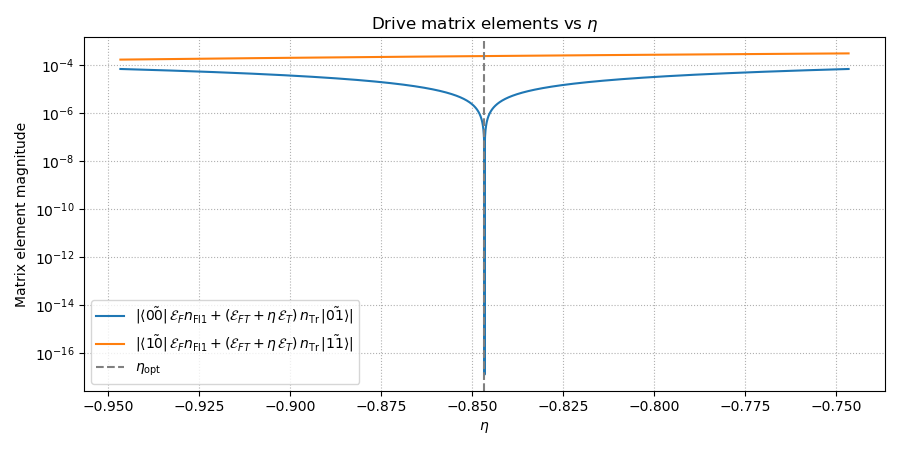

In [103]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
# --- sweep around your chosen center (opteta_p must be defined)
eta_values = np.linspace(eta - .1, eta + .1, 15001)

# --- dressed computational kets
e1 = dressed_epairs[0, 0][1]  # |~00>
e2 = dressed_epairs[0, 1][1]  # |~01>
e3 = dressed_epairs[1, 0][1]  # |~10>
e4 = dressed_epairs[1, 1][1]  # |~11>

# --- precompute the eta-independent part of the operator:
#     O(eta) = EF * n_Fl1_full + (EFT + ET*eta) * n_Tr_full
#            = (EF * n_Fl1_full + EFT * n_Tr_full) + (ET * eta) * n_Tr_full
O_base = EF * n_Fl1_full + EFT * n_Tr_full
O_tr   = ET * n_Tr_full  # this multiplies eta_p each step

# --- compute matrix elements for each eta_p
matrix_elements_00_01 = [
    (O_base + eta_p * O_tr).matrix_element(e1, e2) for eta_p in eta_values
]
matrix_elements_10_11 = [
    (O_base + eta_p * O_tr).matrix_element(e3, e4) for eta_p in eta_values
]

# --- magnitudes (you can also keep phases if you want)
magnitudes_00_01 = np.abs(matrix_elements_00_01)
magnitudes_10_11 = np.abs(matrix_elements_10_11)

# --- plotting
plt.figure(figsize=(9, 4.5))
plt.semilogy(
    eta_values, magnitudes_00_01,
    label=(r'$|\langle \tilde{00} |\, \mathcal{E}_F n_{\mathrm{Fl1}}'
           r'+(\mathcal{E}_{FT}+\eta\,\mathcal{E}_T)\,n_{\mathrm{Tr}} \,| \tilde{01}\rangle|$')
)
plt.semilogy(
    eta_values, magnitudes_10_11,
    label=(r'$|\langle \tilde{10} |\, \mathcal{E}_F n_{\mathrm{Fl1}}'
           r'+(\mathcal{E}_{FT}+\eta\,\mathcal{E}_T)\,n_{\mathrm{Tr}} \,| \tilde{11}\rangle|$')
)

plt.axvline(eta, color='gray', linestyle='--', label=r'$\eta_{\mathrm{opt}}$')
plt.xlabel(r'$\eta$')
plt.ylabel('Matrix element magnitude')
plt.title('Drive matrix elements vs $\eta$')
plt.legend()
plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.show()


nF_10_11 =  (0.016426225355465705+7.033328526986245e-17j)
nF_00_01 =  (-0.007036428028667852+1.2948655729074146e-15j)
nT =  (1.290266540390636-2.3224959906574207e-16j)
eta =  -0.8465896224883769


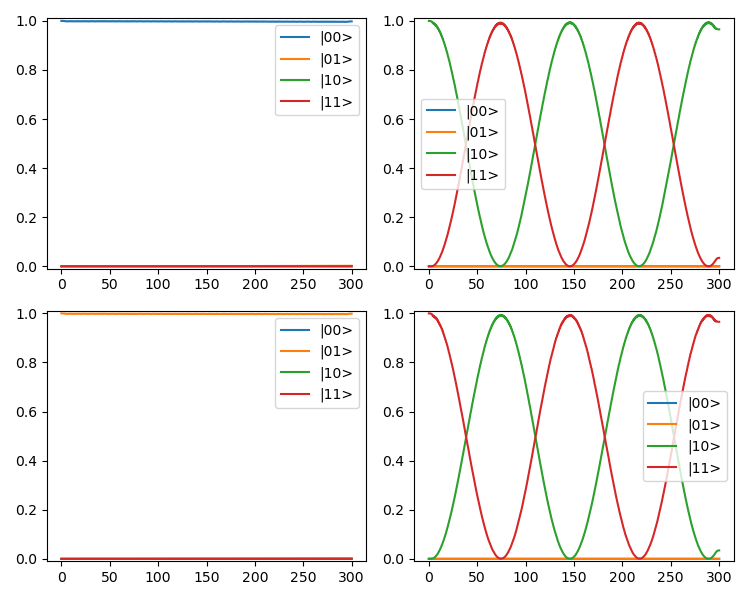

In [104]:
#trying to get the time evolution with different envelopes

def envelop_function(t, tg, t_r):
    if t < t_r:
        fnct = np.sin(np.pi * t / 2 / t_r) ** 2
    elif t < tg - t_r:
        fnct = 1.
    else:
        fnct = np.sin(np.pi * (tg - t) / 2 / t_r) ** 2
    return fnct


def time_dep(t, args):
    w_d = args['w_d']
    return 2 *3.14* np.cos(w_d*t) * envelop_function(t, args['t_g'], args['t_r'])

# EF = .22/22.5 # keeping the same as FUN5
# EFT  = 0.02* EF
# ET   = .06/117.5 # keeping it similar to UMA5

nF_00_01   = (n_Fl1_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1]))
nF_10_11   = (n_Fl1_full.matrix_element(dressed_epairs[1, 0][1], dressed_epairs[1, 1][1]))
nT_00_01   = (n_Tr_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1]))

print('nF_10_11 = ', nF_10_11)
print('nF_00_01 = ', nF_00_01)
print('nT = ', nT)

t_r = 5
t_g = 300
t_list = np.linspace(0, t_g, 3000)
alpha =30
w_d = (dressed_epairs[1, 1][0] - dressed_epairs[1, 0][0])

args = {'t_g': t_g, 'w_d' : w_d, 't_r': t_r}

def eta(EF, EFT, ET, nF, nT):
    """
       Compute eta from the drive cancellation equation:
       eta = - ( EF*nF + EFT*nT ) / ( ET*nT )
    """
    numerator = EF * nF + EFT * nT
    denominator = ET * nT
    return - numerator / denominator

eta = np.real(eta(EF, EFT, ET, nF_00_01, nT_00_01)) # means no selective darkening
print('eta = ', eta)

H_tot = [H_full, [alpha * (EF * n_Fl1_full + EFT * n_Tr_full + eta * ET * n_Tr_full), time_dep]]


def prob_lists(psi):
    p_lists = [[] for _ in range(4)]
    for ndx in range(len(psi)):
        psi_t = psi[ndx]
        for i in range(4):
            idx1 = i // 2
            idx2 = i % 2
            p_lists[i].append(np.abs(psi_t.overlap(dressed_epairs[idx1, idx2][1]))**2)
    return p_lists

def temp_opt_freq_gen(H_tot, args):
    fig, axs = plt.subplots(2, 2, figsize=(7.5, 6))  # Create 2x2 subplots
    axs = axs.flatten()  # Flatten the 2D array for easier iteration

    initial_states = [
        dressed_epairs[0, 0][1],
        dressed_epairs[1, 0][1],
        dressed_epairs[0, 1][1],
        dressed_epairs[1, 1][1],
    ]

    for i, initial_state in enumerate(initial_states):
        p_lists = prob_lists(qt.sesolve(H_tot, initial_state, t_list, args=args).states)

        # Plot only curves with values above 1e-3
        for j, p_list in enumerate(p_lists):
            if any(p > 0 for p in p_list):
                label = "|" + str(j // 2) + str(j % 2) + ">"
                # axs[i].semilogy(t_list, p_list, label=label)
                axs[i].plot(t_list, p_list, label=label)

        axs[i].set_ylim(-0.01, 1.01)
        axs[i].legend()
        axs[i].set_facecolor('white')

    plt.tight_layout()
    plt.show()

temp_opt_freq_gen(H_tot, args)

In [105]:
nF   = (n_Fl1_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1]))
nT   = (n_Tr_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1]))
# EF = .22/22.5 # keeping the same as FUN5
# EFT  = 0.02* EF
# ET   = .06/117.5 # keeping it similar to UMA5

def eta(EF, EFT, ET, nF, nT):
    numerator = EF * nF + EFT * nT
    denominator = ET * nT
    return - numerator / denominator

eta_p = eta(EF, EFT, ET, nF, nT)
alpha = 32.5
detuning = 0.9999
t_g = 50
t_r = 5
t_list = np.linspace(0, t_g, 1000)

initial_guess = [alpha, eta_p, detuning]


result = opt.minimize(abs_fidelity_CX1_with_crosstalk, initial_guess, args=(t_g, t_r, EF, EFT, ET), method='Nelder-Mead', options={'fatol': 0.00001, 'xatol': 0.00001})
optalpha, opteta_p, optdetuning = result.x

w_d = (dressed_epairs[1, 1][0] - dressed_epairs[1, 0][0])*optdetuning
H_tot = [H_full, [optalpha * (EF * n_Fl1_full + (EFT + ET * opteta_p) * n_Tr_full), time_dep]]

args = {'t_g': t_g, 'w_d' : w_d, 't_r': t_r}

U_act = np.abs(U_full2comp(gate(H_tot, args)).full())

max_fidelity = -result.fun

a = 1 - U_act[0,0]
b = 1 - U_act[1,1]
c = 1 - U_act[2,3]
d = 1 - U_act[3,2]

dark = 2*(a + b)/5
flip = 2*(c + d)/5

bright = 2/5 * abs(U_act[0,1])

leak = abs(1 - np.trace(np.transpose(U_act)@U_act)/4)


print(f"dark = {dark:.3e}, flip = {flip:.3e}, leak = {leak:.3e}, max_fidelity = {max_fidelity:.6f}")

opt_names = ("optalpha", "opteta_p", "optdetuning")
opt_vals = result.x
print("Optimized parameters:")
for name, val in zip(opt_names, opt_vals):
    print(f"  {name:>12s} = {val:.6g}")

print(f"Optimizer success: {result.success}, nit: {getattr(result, 'nit', 'N/A')}, message: {result.message}")


 /opt/homebrew/Caskroom/miniconda/base/envs/scqubits_copy/lib/python3.12/site-packages/qutip/solver/options.py: 16

dark = 1.082e-06, flip = 1.521e-04, leak = 1.837e-04, max_fidelity = 0.999810
Optimized parameters:
      optalpha = 47.406+0j
      opteta_p = -0.840255-1.89111e-14j
   optdetuning = 1.00009+0j
Optimizer success: True, nit: 82, message: Optimization terminated successfully.


In [67]:
print('t_g, optalpha, opteta_p, optdetuning = ', t_g, optalpha, opteta_p, optdetuning)

t_g, optalpha, opteta_p, optdetuning =  50 (33.210338704592644+0j) (-0.08184668781383009-9.116805123956984e-16j) (1.0000896756037987+0j)


 /opt/homebrew/Caskroom/miniconda/base/envs/scqubits_copy/lib/python3.12/site-packages/matplotlib/cbook.py: 1719ComplexWarning: Casting complex values to real discards the imaginary part
 /opt/homebrew/Caskroom/miniconda/base/envs/scqubits_copy/lib/python3.12/site-packages/matplotlib/cbook.py: 1355

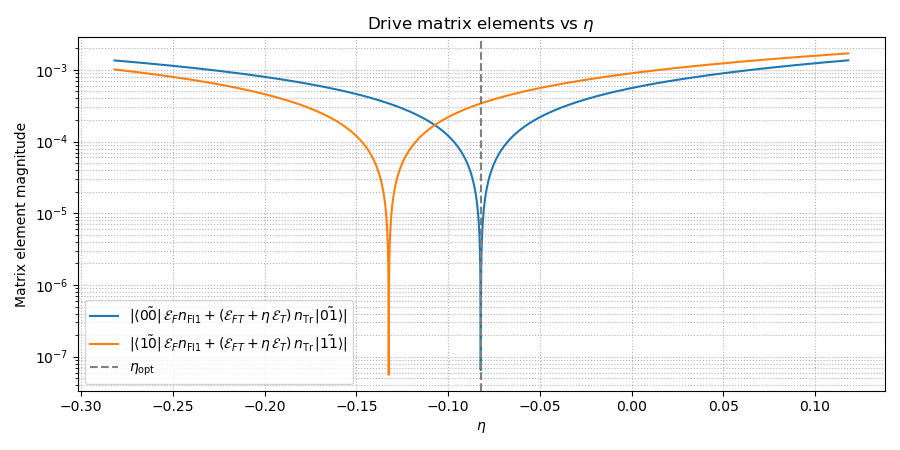

In [68]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
# --- sweep around your chosen center (opteta_p must be defined)
eta_values = np.linspace(opteta_p - .2, opteta_p + .2, 15001)

# --- dressed computational kets
e1 = dressed_epairs[0, 0][1]  # |~00>
e2 = dressed_epairs[0, 1][1]  # |~01>

e3 = dressed_epairs[1, 0][1]  # |~10>
e4 = dressed_epairs[1, 1][1]  # |~11>

# --- precompute the eta-independent part of the operator:
#     O(eta) = EF * n_Fl1_full + (EFT + ET*eta) * n_Tr_full
#            = (EF * n_Fl1_full + EFT * n_Tr_full) + (ET * eta) * n_Tr_full
O_base = EF * n_Fl1_full + EFT * n_Tr_full
O_tr   = ET * n_Tr_full  # this multiplies eta_p each step

# --- compute matrix elements for each eta_p
matrix_elements_00_01 = [
    (O_base + eta_p * O_tr).matrix_element(e1, e2) for eta_p in eta_values
]
matrix_elements_10_11 = [
    (O_base + eta_p * O_tr).matrix_element(e3, e4) for eta_p in eta_values
]

# --- magnitudes (you can also keep phases if you want)
magnitudes_00_01 = np.abs(matrix_elements_00_01)
magnitudes_10_11 = np.abs(matrix_elements_10_11)

# --- plotting
plt.figure(figsize=(9, 4.5))
plt.semilogy(
    eta_values, magnitudes_00_01,
    label=(r'$|\langle \tilde{00} |\, \mathcal{E}_F n_{\mathrm{Fl1}}'
           r'+(\mathcal{E}_{FT}+\eta\,\mathcal{E}_T)\,n_{\mathrm{Tr}} \,| \tilde{01}\rangle|$')
)
plt.semilogy(
    eta_values, magnitudes_10_11,
    label=(r'$|\langle \tilde{10} |\, \mathcal{E}_F n_{\mathrm{Fl1}}'
           r'+(\mathcal{E}_{FT}+\eta\,\mathcal{E}_T)\,n_{\mathrm{Tr}} \,| \tilde{11}\rangle|$')
)

plt.axvline(opteta_p, color='gray', linestyle='--', label=r'$\eta_{\mathrm{opt}}$')
plt.xlabel(r'$\eta$')
plt.ylabel('Matrix element magnitude')
plt.title('Drive matrix elements vs $\eta$')
plt.legend()
plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.show()


In [44]:
print('EF, EFT, ET = ', EF, EFT, ET)
print('nF, nT = ', nF, nT)
print('eta_p = ', opteta_p)
t_g

EF, EFT, ET =  0.010562600812347406 0.0005281300406173704 0.005983408769066786
nF, nT =  (0.006554692531284802-1.0000652754191746e-15j) (-1.2475997995206842-2.5386388404579354e-16j)
eta_p =  (-0.07811234520491679-1.4011860354585263e-15j)


50

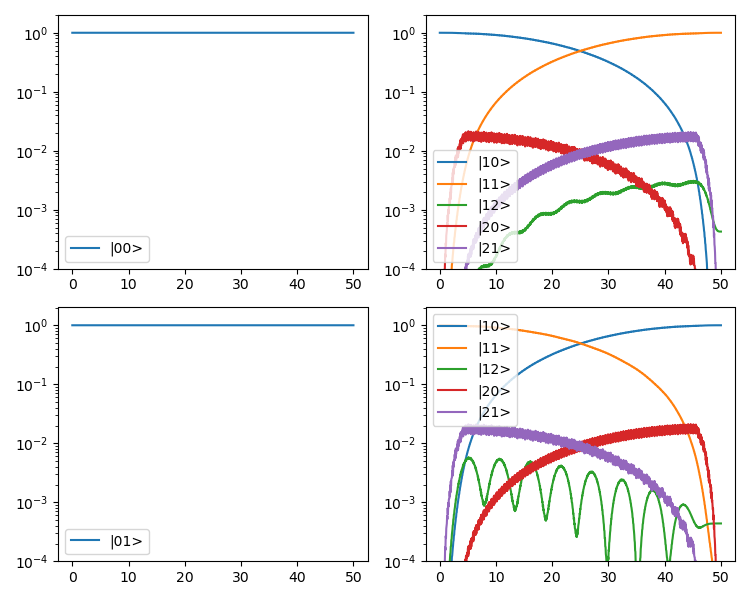

In [69]:

check = False
if check:
    alpha = 180
    detuning = 1
    t_g = 50
    t_r = 5
    t_list = np.linspace(0, t_g, 1000)
    w_d = (dressed_epairs[1, 1][0] - dressed_epairs[1, 0][0])*detuning
    H_tot = [H_full, [alpha * (EF * n_Fl1_full + (EFT + ET * eta_p) * n_Tr_full), time_dep]]
else:
    H_tot = [H_full, [optalpha * (EF * n_Fl1_full + (EFT + ET * opteta_p) * n_Tr_full), time_dep]]


def prob_lists(psi):
    p_lists = [[] for _ in range(9)]
    for ndx in range(len(psi)):
        psi_t = psi[ndx]
        for i in range(8):
            idx1 = i // 3
            idx2 = i % 3
            p_lists[i].append(np.abs(psi_t.overlap(dressed_epairs[idx1, idx2][1]))**2)
    return p_lists

def temp_opt_freq_gen(H_tot, args):
    fig, axs = plt.subplots(2, 2, figsize=(7.5, 6))  # Create 2x2 subplots
    axs = axs.flatten()  # Flatten the 2D array for easier iteration

    initial_states = [
        dressed_epairs[0, 0][1],
        dressed_epairs[1, 0][1],
        dressed_epairs[0, 1][1],
        dressed_epairs[1, 1][1],
    ]

    for i, initial_state in enumerate(initial_states):
        p_lists = prob_lists(qt.sesolve(H_tot, initial_state, t_list, args=args).states)

        # Plot only curves with values above 1e-3
        for j, p_list in enumerate(p_lists):
            if any(p > 1e-4 for p in p_list):
                label = "|" + str(j // 3) + str(j % 3) + ">"
                axs[i].semilogy(t_list, p_list, label=label)

        axs[i].set_ylim(1e-4, 2)
        axs[i].legend()
        axs[i].set_facecolor('white')

    plt.tight_layout()
    plt.show()

temp_opt_freq_gen(H_tot, args)

In [ ]:
## FT system GUI

## FT system GUI

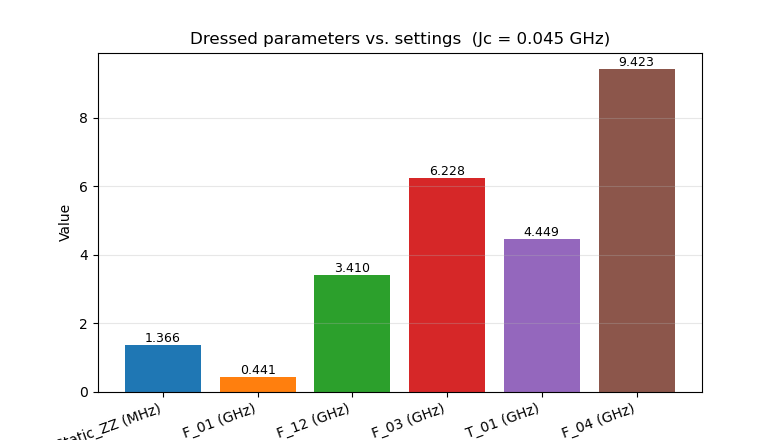

In [96]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
import scqubits as scq

# ---- helpers ----
def compute_params(EJF, ECF, ELF, EJQ, ECQ, Jc, k=120, trunc=6):
    Fl1 = scq.Fluxonium(EJ=EJF, EC=ECF, EL=ELF, flux=0.5, cutoff=k, truncated_dim=trunc)
    Tr  = scq.Transmon(EJ=EJQ, EC=ECQ, ng=0, ncut=k, truncated_dim=trunc)
    full = scq.HilbertSpace([Fl1, Tr])
    full.add_interaction(g=Jc, op1=(Fl1.n_operator(), Fl1), op2=(Tr.n_operator(), Tr))
    full.generate_bare_esys()
    full.generate_lookup()

    H = 2*np.pi*full.hamiltonian()
    evals = (H.eigenenergies() - H.eigenenergies()[0]) / (2*np.pi)  # GHz

    def di(i, j): return full.dressed_index((i, j))
    e_11 = evals[di(1,1)]; e_10 = evals[di(1,0)]; e_01 = evals[di(0,1)]; e_00 = evals[di(0,0)]
    e_20 = evals[di(2,0)]; e_30 = evals[di(3,0)]; e_40 = evals[di(4,0)]

    zz_MHz = (e_11 - e_10 - e_01 + e_00) * 1e3
    F01 = (e_10 - e_00)
    F12 = (e_20 - e_10)
    F03 = (e_30 - e_00)
    T01 = (e_01 - e_00)
    F04 = (e_40 - e_00)

    labels = ["Static_ZZ (MHz)","F_01 (GHz)","F_12 (GHz)","F_03 (GHz)","T_01 (GHz)","F_04 (GHz)"]
    vals   = [zz_MHz, F01, F12, F03, T01, F04]
    return labels, vals

def stepper(sl, step=0.001, minus_label="−0.001", plus_label="+0.001"):
    minus = widgets.Button(description=minus_label)
    plus  = widgets.Button(description=plus_label)
    def dec(_): sl.value = sl.value - step
    def inc(_): sl.value = sl.value + step
    minus.on_click(dec); plus.on_click(inc)
    return widgets.HBox([sl, minus, plus])

# ---- initial values from your JSON dict ----
EJF0 = FT_Device['fluxonium']['EJ']
ECF0 = FT_Device['fluxonium']['EC']
ELF0 = FT_Device['fluxonium']['EL']
EJQ0 = FT_Device['transmon']['EJ']
ECQ0 = FT_Device['transmon']['EC']
Jc0  = FT_Device['Jc']

# reasonable slider ranges around initial values
def rng(val, frac=1, step=0.01):
    return dict(min=max(1e-6, val*(1-frac)), max=val*(1+frac), step=step)

# sliders (GHz)
sl_EJF = widgets.FloatSlider(description="Flux E_J (GHz)", value=EJF0, **rng(EJF0))
sl_ECF = widgets.FloatSlider(description="Flux E_C (GHz)", value=ECF0, **rng(ECF0))
sl_ELF = widgets.FloatSlider(description="Flux E_L (GHz)", value=ELF0, **rng(ELF0))
sl_EJQ = widgets.FloatSlider(description="Trans E_J (GHz)", value=EJQ0, **rng(EJQ0))
sl_ECQ = widgets.FloatSlider(description="Trans E_C (GHz)", value=ECQ0, **rng(ECQ0))

# Jc with 3-decimal readout; larger step (0.05) and matching ± buttons
sl_Jc  = widgets.FloatSlider(
    description="Jc (GHz)", value=Jc0,
    **rng(Jc0, frac=1.0, step=0.001),
    readout_format=".3f"   # show Jc to three decimals
)

ui = widgets.VBox([
    stepper(sl_EJF, step=0.01, minus_label="−0.01", plus_label="+0.01"),
    stepper(sl_ECF, step=0.01, minus_label="−0.01", plus_label="+0.01"),
    stepper(sl_ELF, step=0.01, minus_label="−0.01", plus_label="+0.01"),
    stepper(sl_EJQ, step=0.01, minus_label="−0.01", plus_label="+0.01"),
    stepper(sl_ECQ, step=0.01, minus_label="−0.01", plus_label="+0.01"),
    stepper(sl_Jc,  step=0.05,  minus_label="−0.05",  plus_label="+0.05"),
])

# ---- figure ----
fig, ax = plt.subplots(figsize=(7.8, 4.4))

def update(*_):
    labels, vals = compute_params(sl_EJF.value, sl_ECF.value, sl_ELF.value,
                                  sl_EJQ.value, sl_ECQ.value, sl_Jc.value)
    ax.clear()
    colors = ["C0","C1","C2","C3","C4","C5"]
    bars = ax.bar(range(len(vals)), vals, color=colors)
    ax.set_xticks(range(len(vals)), labels, rotation=20, ha='right')
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylabel("Value")
    ax.set_title(f"Dressed parameters vs. settings  (Jc = {sl_Jc.value:.3f} GHz)")
    for b, v in zip(bars, vals):
        ax.text(b.get_x()+b.get_width()/2, b.get_height(),
                f"{v:.3f}", ha='center', va='bottom', fontsize=9)
    fig.canvas.draw_idle()

for sl in (sl_EJF, sl_ECF, sl_ELF, sl_EJQ, sl_ECQ, sl_Jc):
    sl.observe(update, names='value')

display(ui)
update()


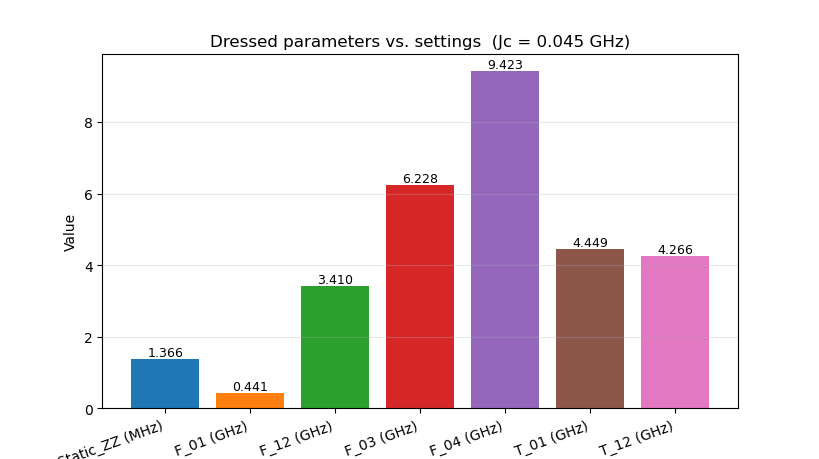

In [97]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
import scqubits as scq

# ---- helpers ----
def compute_params(EJF, ECF, ELF, EJQ, ECQ, Jc, k=120, trunc=6):
    Fl1 = scq.Fluxonium(EJ=EJF, EC=ECF, EL=ELF, flux=0.5, cutoff=k, truncated_dim=trunc)
    Tr  = scq.Transmon(EJ=EJQ, EC=ECQ, ng=0, ncut=k, truncated_dim=trunc)
    full = scq.HilbertSpace([Fl1, Tr])
    full.add_interaction(g=Jc, op1=(Fl1.n_operator(), Fl1), op2=(Tr.n_operator(), Tr))
    full.generate_bare_esys()
    full.generate_lookup()

    H = 2*np.pi*full.hamiltonian()
    evals = (H.eigenenergies() - H.eigenenergies()[0]) / (2*np.pi)  # GHz

    def di(i, j): return full.dressed_index((i, j))
    e_00 = evals[di(0,0)]
    e_01 = evals[di(0,1)]
    e_02 = evals[di(0,2)]  # <-- added for T_12
    e_10 = evals[di(1,0)]
    e_11 = evals[di(1,1)]
    e_20 = evals[di(2,0)]
    e_30 = evals[di(3,0)]
    e_40 = evals[di(4,0)]

    # values to plot
    zz_MHz = (e_11 - e_10 - e_01 + e_00) * 1e3
    F01 = (e_10 - e_00)
    F12 = (e_20 - e_10)
    F03 = (e_30 - e_00)
    T01 = (e_01 - e_00)
    T12 = (e_02 - e_01)  # <-- transmon 1-2
    F04 = (e_40 - e_00)

    labels = [
        "Static_ZZ (MHz)",
        "F_01 (GHz)", "F_12 (GHz)", "F_03 (GHz)", "F_04 (GHz)",
        "T_01 (GHz)", "T_12 (GHz)"  # <-- added T_12
    ]
    vals   = [zz_MHz, F01, F12, F03, F04, T01, T12]
    return labels, vals

def stepper(sl, step=0.001, minus_label="−0.001", plus_label="+0.001"):
    minus = widgets.Button(description=minus_label)
    plus  = widgets.Button(description=plus_label)
    def dec(_): sl.value = sl.value - step
    def inc(_): sl.value = sl.value + step
    minus.on_click(dec); plus.on_click(inc)
    return widgets.HBox([sl, minus, plus])

# ---- initial values from your JSON dict ----
EJF0 = FT_Device['fluxonium']['EJ']
ECF0 = FT_Device['fluxonium']['EC']
ELF0 = FT_Device['fluxonium']['EL']
EJQ0 = FT_Device['transmon']['EJ']
ECQ0 = FT_Device['transmon']['EC']
Jc0  = FT_Device['Jc']

# reasonable slider ranges around initial values
def rng(val, frac=1, step=0.01):
    return dict(min=max(1e-6, val*(1-frac)), max=val*(1+frac), step=step)

# sliders (GHz)
sl_EJF = widgets.FloatSlider(description="Flux E_J (GHz)", value=EJF0, **rng(EJF0))
sl_ECF = widgets.FloatSlider(description="Flux E_C (GHz)", value=ECF0, **rng(ECF0))
sl_ELF = widgets.FloatSlider(description="Flux E_L (GHz)", value=ELF0, **rng(ELF0))
sl_EJQ = widgets.FloatSlider(description="Trans E_J (GHz)", value=EJQ0, **rng(EJQ0))
sl_ECQ = widgets.FloatSlider(description="Trans E_C (GHz)", value=ECQ0, **rng(ECQ0))

# Jc with 3-decimal readout
sl_Jc  = widgets.FloatSlider(
    description="Jc (GHz)", value=Jc0,
    **rng(Jc0, frac=1.0, step=0.001),
    readout_format=".3f"
)

ui = widgets.VBox([
    stepper(sl_EJF, step=0.01, minus_label="−0.01", plus_label="+0.01"),
    stepper(sl_ECF, step=0.01, minus_label="−0.01", plus_label="+0.01"),
    stepper(sl_ELF, step=0.01, minus_label="−0.01", plus_label="+0.01"),
    stepper(sl_EJQ, step=0.01, minus_label="−0.01", plus_label="+0.01"),
    stepper(sl_ECQ, step=0.01, minus_label="−0.01", plus_label="+0.01"),
    stepper(sl_Jc,  step=0.05, minus_label="−0.05", plus_label="+0.05"),
])

# ---- figure ----
fig, ax = plt.subplots(figsize=(8.2, 4.6))

def update(*_):
    labels, vals = compute_params(sl_EJF.value, sl_ECF.value, sl_ELF.value,
                                  sl_EJQ.value, sl_ECQ.value, sl_Jc.value)
    ax.clear()
    colors = ["C0","C1","C2","C3","C4","C5","C6"]  # 7 entries
    bars = ax.bar(range(len(vals)), vals, color=colors[:len(vals)])
    ax.set_xticks(range(len(vals)), labels, rotation=20, ha='right')
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylabel("Value")
    ax.set_title(f"Dressed parameters vs. settings  (Jc = {sl_Jc.value:.3f} GHz)")
    for b, v in zip(bars, vals):
        ax.text(b.get_x()+b.get_width()/2, b.get_height(),
                f"{v:.3f}", ha='center', va='bottom', fontsize=9)
    fig.canvas.draw_idle()

for sl in (sl_EJF, sl_ECF, sl_ELF, sl_EJQ, sl_ECQ, sl_Jc):
    sl.observe(update, names='value')

display(ui)
update()
